# Opposite test


## Packages

In [1]:
import os

# os.chdir('/home/acuevas/Bureau/S2_ALEXANDRA/OPTOOLS/PYTHON/Carte_courant')


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.fft import fftn
from scipy.fft import fft
from scipy.fft import fftshift
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from spectral_analysis_functions_3img import*
from scipy.optimize import fminbound, fsolve

In [2]:
#  Very simple test of least-square estimation from 3 1D images at 3 different times
# using exactly periodic signal (no windowing , leaking ...) 

## Paramètres


In [3]:
# Définition des variables
L = 50
g = 9.81
k = 1 * np.pi / L
sig = np.sqrt(g * k)
T = 2 * np.pi / sig
C0 = np.sqrt(g / k)

nx = 100
dx = 10
x = np.linspace(0, (nx - 1) * dx, nx)

t1 = 0
t2 = 0.5
t3 = 1.0
imgtimes = np.array([t1, t2, t3])  # Vector of times of the image acquisition

# Warning: this phase unwrapping should be corrected to take into account current ... 
philinp = (C0 * k * t3 + np.pi) % (2 * np.pi) - np.pi  # linear zero-current phase with phase wrapping
philinm = (-C0 * k * t3 + np.pi) % (2 * np.pi) - np.pi
sig = np.sqrt(g * k)

U = 0.2
Aa = 1  # Complex amplitude of rightward propagating waves
Ba = 0.05  # Complex amplitude of leftward propagating waves
noise_amplitude = 0.05;

import numpy as np

NMC = 5000             # number of Monte Carlo realisations
# NMC = 50000            # better convergence
MMC = 1

# Initialize arrays to store results
Um1 = np.zeros(MMC)
Us1 = np.zeros(MMC)
Us3 = np.zeros(MMC)
Um2 = np.zeros(MMC)
Um3 = np.zeros(MMC)
Um4 = np.zeros(MMC)

Monte Carlo iteration: 1


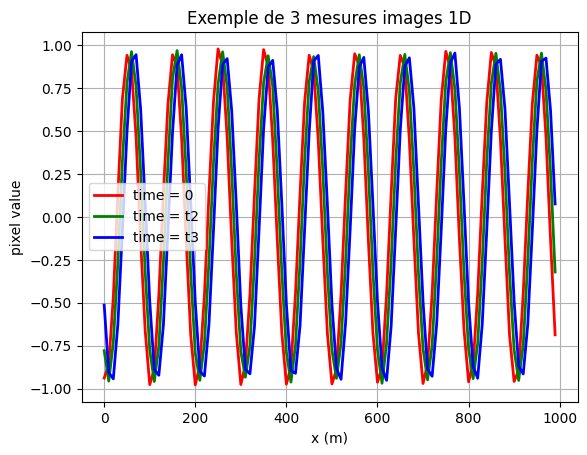

/tmp/ipykernel_36724/2719646917.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  Aall[iMC] = Ac
/tmp/ipykernel_36724/2719646917.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  Ball[iMC] = Bc


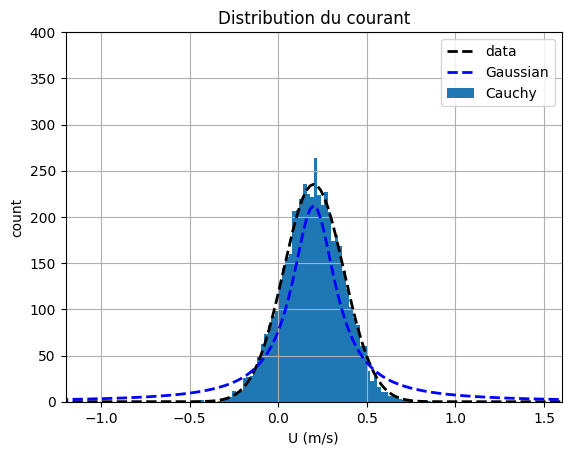

stdU_LS: 0.16954487104289234
stdU_phi2: 0.7947752966124472


In [4]:
for jMC in range(MMC):
    print(f'Monte Carlo iteration: {jMC + 1}')
    Ucall = np.zeros(NMC)
    Aall = np.zeros(NMC)
    Ball = np.zeros(NMC)
    Upall = np.zeros(NMC)
    indOK = np.zeros(NMC)
    eps2all = np.zeros(NMC)
    EA = 0
    EB = 0

    F3sum = 0
    F2sum = 0
    F1sum = 0
    Nok = 0

    for iMC in range(NMC):
        phia = np.random.rand() * 2 * np.pi
        phib = np.random.rand() * 2 * np.pi
        A = Aa * np.exp(1j * phia)
        B = Ba * np.exp(1j * phib)
        na = noise_amplitude * (np.random.rand(3, nx) + 1j * np.random.rand(3, nx))
        nt = noise_amplitude * np.random.rand(3, nx)

        f1 = np.real(A * np.exp(1j * (k * x - (sig - k * U) * t1)) + B * np.exp(1j * (k * x + (sig + k * U) * t1))) * (1 - 0.5 * noise_amplitude + nt[0])
        f2 = np.real(A * np.exp(1j * (k * x - (sig - k * U) * t2)) + B * np.exp(1j * (k * x + (sig + k * U) * t2))) * (1 - 0.5 * noise_amplitude + nt[1])
        f3 = np.real(A * np.exp(1j * (k * x - (sig - k * U) * t3)) + B * np.exp(1j * (k * x + (sig + k * U) * t3))) * (1 - 0.5 * noise_amplitude + nt[2])

        if iMC == 0:
            plt.figure(1)
#             plt.title('Example of 3 measured 1D images')
            plt.title('Exemple de 3 mesures images 1D')

            plt.plot(x, f1, 'r-', x, f2, 'g-', x, f3, 'b-', linewidth=2)
            plt.xlabel('x (m)')
            plt.ylabel('pixel value')
            plt.legend(['time = 0', 'time = t2', 'time = t3'])
            plt.grid(True)
            plt.show()

        f1hat = fft(f1) / nx
        Imax = np.argmax(np.abs(f1hat))
        F1 = 2 * f1hat[Imax]
        f2hat = fft(f2) / nx
        F2 = 2 * f2hat[Imax]
        f3hat = fft(f3) / nx
        F3 = 2 * f3hat[Imax]

        Ufun = lambda Uc: np.abs(ULSmin(Uc, k, sig, imgtimes, [F1, F2, F3])[0])
        Uc = fminbound(Ufun, -5.1, 5.1)

        U2, Ac, Bc = ULSmin(Uc, k, sig, imgtimes, [F1, F2, F3])

        if np.abs(Uc) < 5:
            Nok += 1
            eps2all[iMC] = U2
            EA += np.abs(Ac) ** 2
            EB += np.abs(Bc) ** 2
            Aall[iMC] = Ac
            Ball[iMC] = Bc
            indOK[iMC] = 1
            Ucall[iMC] = Uc

        F1a = np.angle(F1)
        F1sum += F1 * np.exp(-1j * F1a)
        F2sum += F2 * np.exp(-1j * F1a)
        F3sum += F3 * np.exp(-1j * F1a)
        Upall[iMC] = (np.angle(F3 * np.conj(F1)) - philinm) / k / t3

    Ufun = lambda Uc: ULSmin(Uc, k, sig, imgtimes, [F1sum, F2sum, F3sum])[0]
    Um2[jMC] = fminbound(Ufun, -5.1, 5.1)
    Ufval, Ac, Bc = ULSmin(Um2[jMC], k, sig, imgtimes, [F1sum, F2sum, F3sum])

    J = np.where(indOK == 1)[0]
    EM = np.mean(eps2all[J])
    Um1[jMC] = np.median(Ucall[J])
    Us1[jMC] = np.std(Ucall[J])
    UW = -((C0 + U) * A - B * (C0 - U) - C0 * (A + B)) / (A + B)
    Um3[jMC] = np.mean(Upall)
    Us3[jMC] = np.std(Upall)
    Um4[jMC] = (np.angle(F3sum * np.conj(F1sum)) - philinm) / k / t3
    H = 4 * EA * EB / (EA + EB) ** 2
    H2 = 4 * np.abs(Ac) ** 2 * np.abs(Bc) ** 2 / (np.abs(Ac) ** 2 + np.abs(Bc) ** 2) ** 2
    Hin = 4 * np.abs(A) ** 2 * np.abs(B) ** 2 / (np.abs(A) ** 2 + np.abs(B) ** 2) ** 2

plt.figure(2)
plt.clf()
plt.hist(Ucall[J], bins=np.arange(-5, 5, 0.02))
plt.title('Distribution du courant')
plt.xlabel('U (m/s)')
plt.ylabel('count')
plt.grid(True)

sigULS = np.std(Ucall[J])
edges = np.arange(-5, 5, 0.02)
gp = NMC * np.exp(-0.5 * (edges - U) ** 2 / sigULS ** 2) / (sigULS * np.sqrt(2 * np.pi)) * 0.02
sig2 = 0.2
a = 0.15
gp2 = NMC * a / ((edges - U) ** 2 + a ** 2) / np.pi * 0.02
gp3 = NMC * np.exp(-0.5 * (edges - U) ** 2 / sig2 ** 2) / (sig2 * np.sqrt(2 * np.pi)) * 0.02
plt.plot(edges, gp, 'k--', edges, gp2, 'b--', linewidth=2)
plt.legend(['data', 'Gaussian', 'Cauchy'])
plt.axis([-1.2, 1.6, 0, 400])
plt.show()

stdU_LS = np.std(Ucall)
stdU_phi2 = np.std(Upall)

print(f'stdU_LS: {stdU_LS}')
print(f'stdU_phi2: {stdU_phi2}')



